In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


In [2]:
# Install required libraries
!pip install pandas==2.2.2
!pip install scikit-learn==1.2.2
!pip install numpy==1.26.4
!pip install matplotlib==3.7.5
!pip install seaborn==0.12.2
!pip install shap==0.44.1
!pip install plotly==5.18.0

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import plotly.express as px

In [4]:
# Custom function to compute Quadratic Weighted Kappa.
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = np.array(y_true)  # Ensure numpy array
    y_pred = np.array(y_pred)  # Ensure numpy array
    
    min_rating = np.min(y_true)
    max_rating = np.max(y_true)
    
    y_pred = np.clip(y_pred, min_rating, max_rating)
    
    hist_true = np.histogram(y_true, bins=max_rating-min_rating+1, range=(min_rating, max_rating+1))[0]
    hist_pred = np.histogram(y_pred, bins=max_rating-min_rating+1, range=(min_rating, max_rating+1))[0]

    O = np.zeros((max_rating-min_rating+1, max_rating-min_rating+1))
    for i in range(len(y_true)):
        O[y_true[i]-min_rating, y_pred[i]-min_rating] += 1

    E = np.outer(hist_true, hist_pred) / len(y_true)
    W = np.zeros((max_rating-min_rating+1, max_rating-min_rating+1))
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] = ((i - j) ** 2.0 / (max_rating - min_rating) ** 2.0)
    
    kappa = 1.0 - (np.sum(W * O) / np.sum(W * E))
    return kappa

In [5]:
# Load Data
train_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
test_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


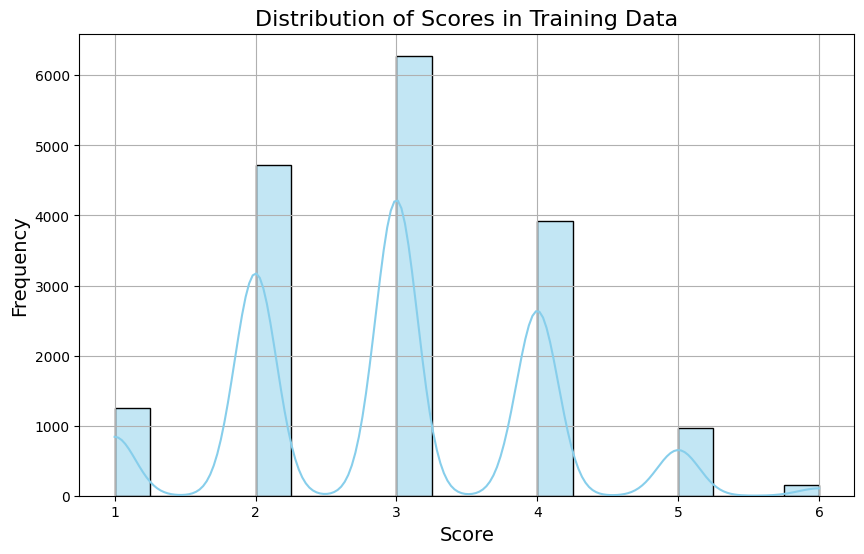

In [6]:
# Distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(train_df['score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Scores in Training Data', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

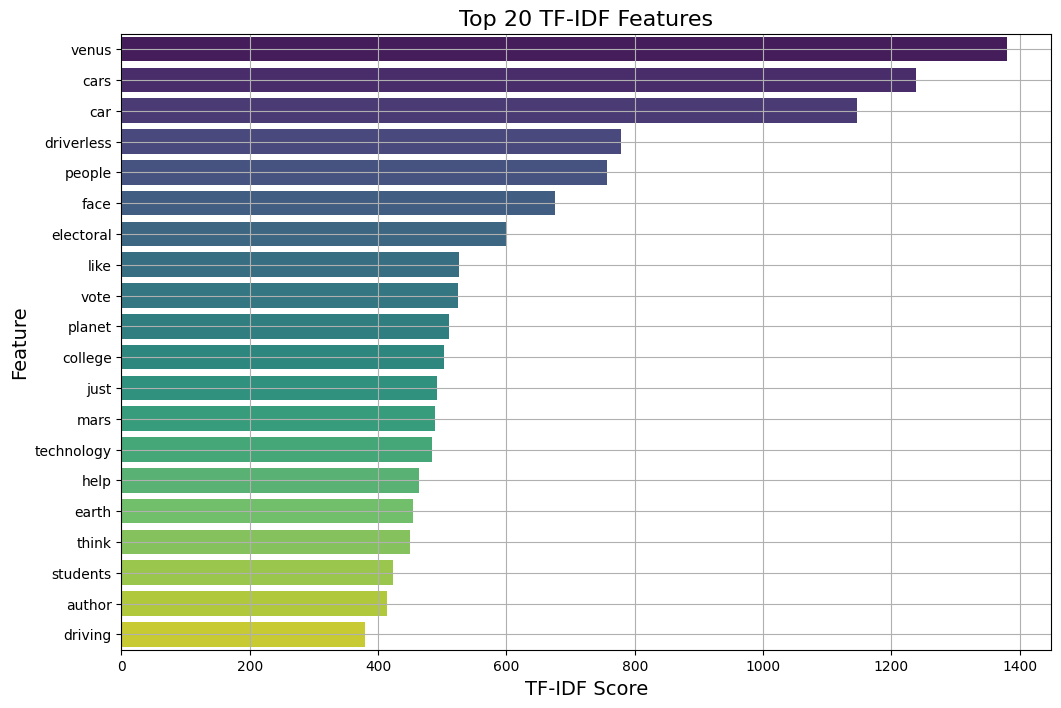

In [7]:
# Feature Extraction
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(train_df['full_text'])
y = train_df['score']

# Extracting TF-IDF feature names
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X.sum(axis=0).A1

# Creating a DataFrame of feature scores
df_tfidf = pd.DataFrame({'Feature': feature_names, 'TF-IDF Score': tfidf_scores})
df_tfidf = df_tfidf.sort_values(by='TF-IDF Score', ascending=False).head(20)

# Plotting the top 20 TF-IDF features
plt.figure(figsize=(12, 8))
sns.barplot(x='TF-IDF Score', y='Feature', data=df_tfidf, palette='viridis')
plt.title('Top 20 TF-IDF Features', fontsize=16)
plt.xlabel('TF-IDF Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True)
plt.show()

In [8]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Model Training
model = Ridge()
params = {'alpha': [0.1, 1.0, 10.0]}
scorer = make_scorer(quadratic_weighted_kappa)
grid = GridSearchCV(model, param_grid=params, scoring=scorer, cv=5)
grid.fit(X_train, y_train)

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/tmp/ipykernel_18/2272189449.py", line 16, in quadratic_weighted_kappa
    O[y_true[i]-min_rating, y_pred[i]-min_rating] += 1
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  Fi

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0]},
             scoring=make_scorer(quadratic_weighted_kappa))

In [10]:
# Evaluation
y_pred = grid.predict(X_val).round().astype(int)
y_pred = np.clip(y_pred, np.min(y_val), np.max(y_val))  # Ensure valid range
kappa = quadratic_weighted_kappa(y_val, y_pred)
print(f'Quadratic Weighted Kappa: {kappa:.4f}')

Quadratic Weighted Kappa: 0.6577


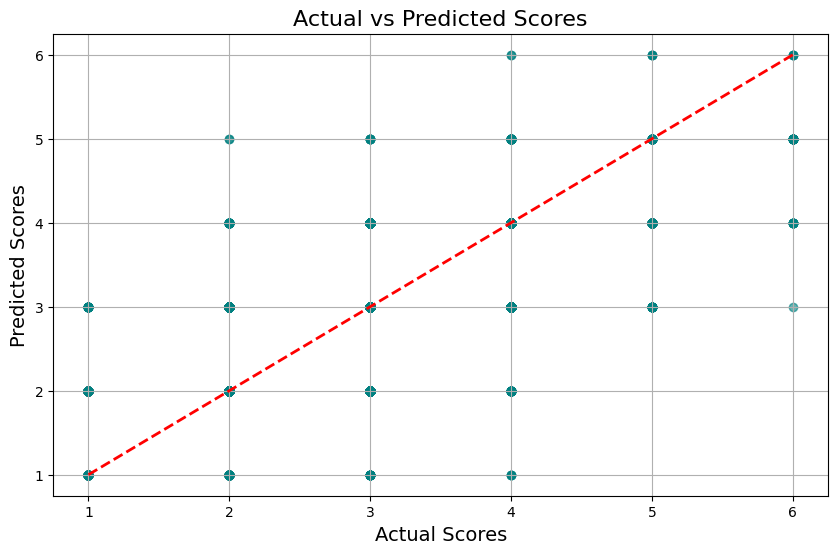

In [11]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Scores', fontsize=16)
plt.xlabel('Actual Scores', fontsize=14)
plt.ylabel('Predicted Scores', fontsize=14)
plt.grid(True)
plt.show()

In [12]:
# Predict Test Data
X_test = vectorizer.transform(test_df['full_text'])
test_df['score'] = grid.predict(X_test).round().astype(int)

In [13]:
test_df

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4


In [14]:
submit = pd.DataFrame(
    {
        'essay_id': test_df['essay_id'],
        'score': test_df['score'] # torch.argmax(outputs.logits, axis=1).to('cpu') + 1
    }
)

In [15]:
submit


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4


In [16]:
submit.to_csv('/kaggle/working/submission.csv', index=False)